In [15]:
# ============================================================
# 0. Setup
# ============================================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, ks_2samp
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier  # or LGBMRegressor depending on target

sns.set(style="whitegrid")

TRAIN_PATH = "train_processed.csv"
TEST_PATH  = "test_processed.csv"
TARGET     = "sii"   # adjust if different

In [16]:
# ============================================================
# 1. Load data and identify actigraphy columns
# ============================================================
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

act_keywords = [
    "enmo", "anglez", "light", "X_", "Y_", "Z_", "battery_voltage",
    "time_of_day", "weekday", "quarter", "sedentary_por", "light_por",
    "moderate_por", "vigorous_por", "non-wear_flag"
]

act_cols = [c for c in train.columns if any(k in c for k in act_keywords)]
act_cols = [c for c in act_cols if c in test.columns]  # ensure overlap

print(f"Actigraphy columns: {len(act_cols)}")

Actigraphy columns: 91


| Family          | Example columns                                                                                                                                                                           | Count | Present in train | Present in test | Short description                                                                |
| --------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----- | ---------------- | --------------- | -------------------------------------------------------------------------------- |
| POR proportions | `sedentary_por`, `light_por`, `moderate_por`                                                                                                                                              | 3     | Yes              | Yes             | Proportion of recorded time spent in sedentary, light, moderate intensity bands. |
| X-axis          | `X_count`, `X_mean`, `X_std`, `X_min`, `X_25%`, `X_50%`, `X_75%`, `X_max`                                                                                                                 | 8     | Yes              | Yes             | Aggregated statistics of raw X-axis acceleration.                                |
| Y-axis          | analogous set: `Y_count`…`Y_max`                                                                                                                                                          | 8     | Yes              | Yes             | Aggregated statistics of raw Y-axis acceleration.                                |
| Z-axis          | analogous set: `Z_count`…`Z_max`                                                                                                                                                          | 8     | Yes              | Yes             | Aggregated statistics of raw Z-axis acceleration.                                |
| ENMO            | `enmo_count`, `enmo_mean`, `enmo_std`, `enmo_min`, `enmo_25%`, `enmo_50%`, `enmo_75%`, `enmo_max`                                                                                         | 8     | Yes              | Yes             | Euclidean Norm Minus One, a standard overall activity magnitude measure.         |
| anglez          | `anglez_count`, `anglez_mean`, `anglez_std`, `anglez_min`, `anglez_25%`, `anglez_50%`, `anglez_75%`, `anglez_max`                                                                         | 8     | Yes              | Yes             | Orientation relative to gravity, sensitive to posture / rest–activity rhythm.    |
| light           | `light_count`, `light_mean`, `light_std`, `light_min`, `light_25%`, `light_50%`, `light_75%`, `light_max`                                                                                 | 8     | Yes              | Yes             | Light exposure over the day, proxy for circadian entrainment.                    |
| battery_voltage | `battery_voltage_count`, `battery_voltage_mean`, `battery_voltage_std`, `battery_voltage_min`, `battery_voltage_25%`, `battery_voltage_50%`, `battery_voltage_75%`, `battery_voltage_max` | 8     | Yes              | Yes             | Device health and possible quality artefacts.                                    |
| time_of_day     | `time_of_day_count`, `time_of_day_mean`, `time_of_day_std`, `time_of_day_min`, `time_of_day_25%`, `time_of_day_50%`, `time_of_day_75%`, `time_of_day_max`                                 | 8     | Yes              | Yes             | Distribution of activity timestamps over 24h (encoded numerically).              |
| weekday         | `weekday_count`, `weekday_mean`, `weekday_std`, `weekday_min`, `weekday_25%`, `weekday_50%`, `weekday_75%`, `weekday_max`                                                                 | 8     | Yes              | Yes             | Distribution of days-of-week for valid wear/activity.                            |
| quarter         | `quarter_count`, `quarter_mean`, `quarter_std`, `quarter_min`, `quarter_25%`, `quarter_50%`, `quarter_75%`, `quarter_max`                                                                 | 8     | Yes              | Yes             | Distribution of recording across calendar quarters (seasonality proxy).          |
| non-wear flag   | `non-wear_flag_count`, `non-wear_flag_mean`, `non-wear_flag_std`, `non-wear_flag_min`, `non-wear_flag_25%`, `non-wear_flag_50%`, `non-wear_flag_75%`                                      | 7     | Yes              | Yes             | Aggregates of binary non-wear indicator across epochs.                           |


,feature,psi,ks_stat,ks_pvalue,train_mean,test_mean
9,X_75%,12.448233,0.870482,0.034231,2.687170e-01,-1.487881e-02
12,Y_mean,12.424312,0.549197,0.407937,2.005970e-02,1.643383e-02
65,battery_voltage_75%,10.915836,0.463855,0.636937,3.987292e+03,4.049094e+03
31,enmo_25%,10.639961,0.733936,0.142757,3.753225e-03,7.526790e-03
84,quarter_mean,10.547523,0.573293,0.365630,2.381168e+00,3.000000e+00
71,time_of_day_25%,10.538108,0.312249,0.969590,2.686126e+13,2.921500e+13
10,X_max,10.519663,0.480924,0.576523,1.672994e+00,1.271108e+00
5,X_std,10.519663,0.659639,0.233044,4.737919e-01,4.026048e-01
52,light_mean,10.519663,0.332329,0.946595,4.024040e+01,2.953415e+01
28,enmo_mean,10.519663,0.347390,0.925128,3.845285e-02,2.965693e-02


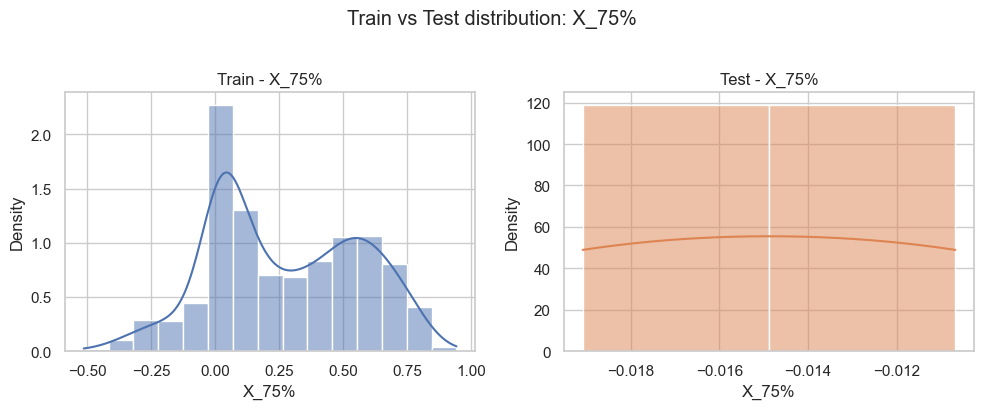

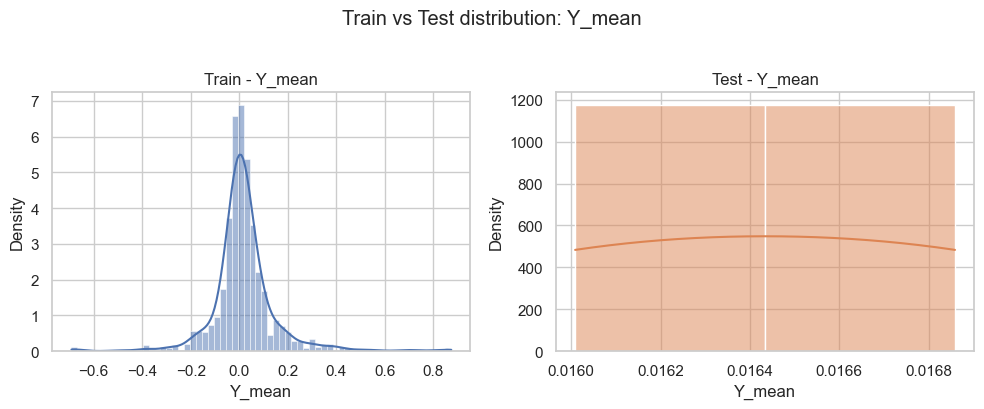

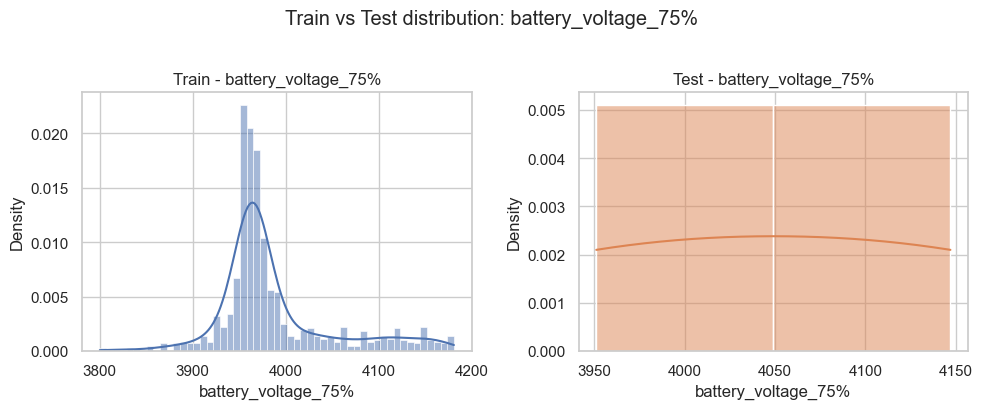

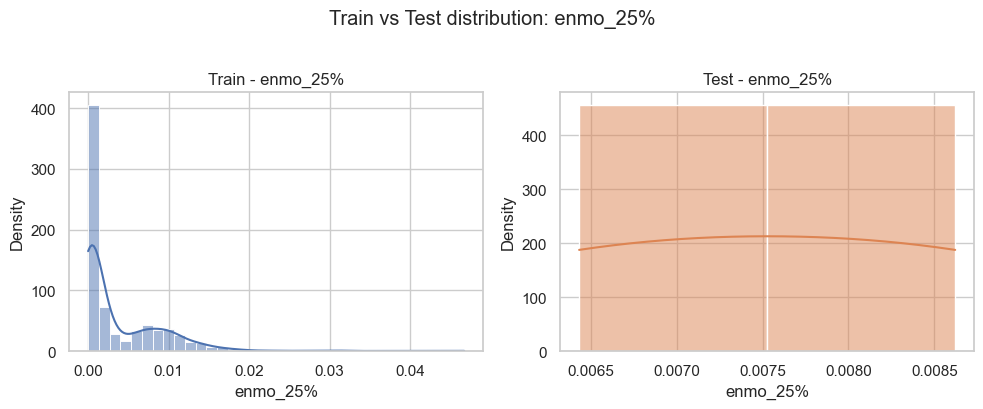

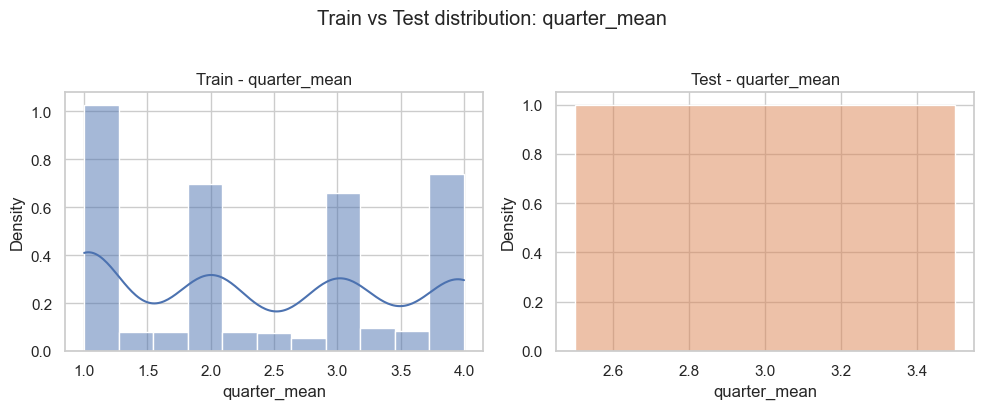

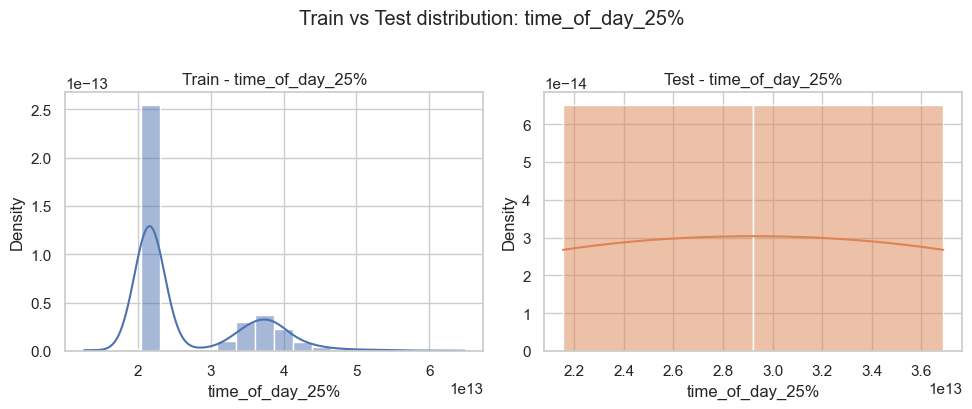

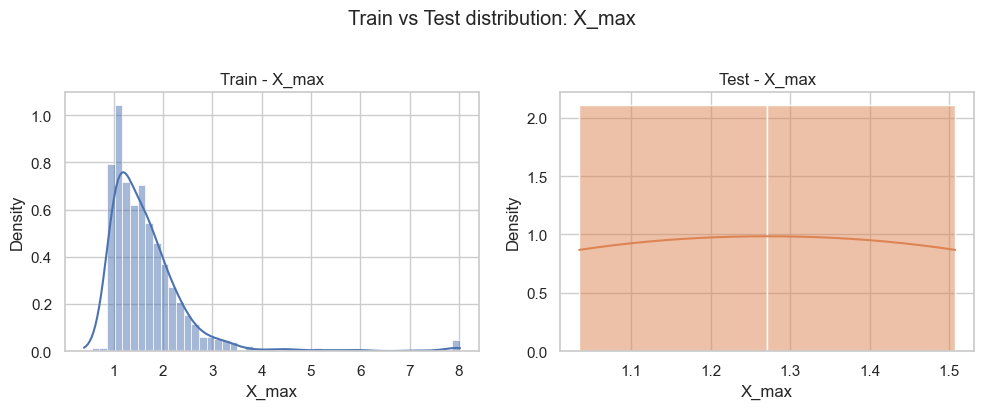

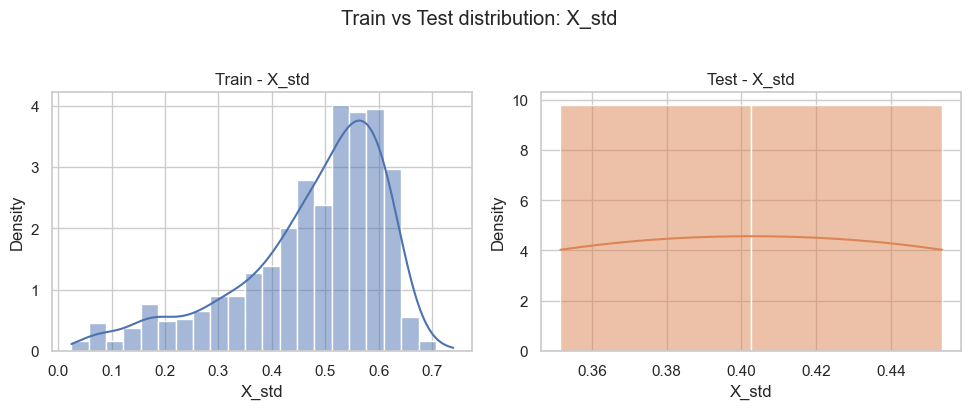

In [17]:
# ============================================================
# 2. Train vs Test Distribution Shift (KDE + PSI + KS)
# ============================================================
def compute_psi(train_vals, test_vals, bins=10):
    t = pd.Series(train_vals).dropna()
    v = pd.Series(test_vals).dropna()
    if t.empty or v.empty:
        return np.nan

    qs = np.quantile(t, np.linspace(0, 1, bins + 1))
    qs = np.unique(qs)
    if len(qs) < 2:
        return np.nan

    t_counts, _ = np.histogram(t, bins=qs)
    v_counts, _ = np.histogram(v, bins=qs)

    t_perc = t_counts / max(t_counts.sum(), 1)
    v_perc = v_counts / max(v_counts.sum(), 1)

    t_perc = np.where(t_perc == 0, 1e-6, t_perc)
    v_perc = np.where(v_perc == 0, 1e-6, v_perc)

    return np.sum((t_perc - v_perc) * np.log(t_perc / v_perc))

shift_records = []
for col in act_cols:
    tr = train[col].dropna()
    te = test[col].dropna()
    if tr.empty or te.empty:
        continue

    psi_val = compute_psi(tr, te)
    ks_stat, ks_p = ks_2samp(tr, te)

    shift_records.append({
        "feature": col,
        "psi": psi_val,
        "ks_stat": ks_stat,
        "ks_pvalue": ks_p,
        "train_mean": tr.mean(),
        "test_mean": te.mean()
    })

shift_df = pd.DataFrame(shift_records).sort_values("psi", ascending=False)
display(shift_df.head(20))

# Plot top-shifted actigraphy features
top_shift_feats = shift_df.head(8)["feature"].tolist()

for col in top_shift_feats:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(train[col], kde=True, stat="density",
                 ax=axes[0], color="C0", label="train")
    axes[0].set_title(f"Train - {col}")

    sns.histplot(test[col], kde=True, stat="density",
                 ax=axes[1], color="C1", label="test")
    axes[1].set_title(f"Test - {col}")

    plt.suptitle(f"Train vs Test distribution: {col}", y=1.02)
    plt.tight_layout()
    plt.show()

## Modeling implications

* You cannot rely on PSI/KS numerically here to reject features — the sample is too small.

* Instead, use them as qualitative checks: look for clearly different modes or truncated ranges in test.

* If a feature shows test values outside train support, cap test to train min/max or consider robust models.

* Adversarial validation (train vs test classifier) could be used, but with n=20 it will be highly unstable.

,skew_train,skew_test,recommended_transform,abs_skew_train
feature,,,,
battery_voltage_max,17.118375,NaN,log1p,17.118375
Z_min,-15.903797,NaN,yeo_johnson,15.903797
anglez_max,-15.892405,NaN,log1p,15.892405
light_25%,15.295407,NaN,log1p,15.295407
time_of_day_max,-12.729137,NaN,log1p,12.729137
time_of_day_min,12.047049,NaN,log1p,12.047049
weekday_min,11.072081,NaN,log1p,11.072081
light_75%,9.520083,NaN,log1p,9.520083
anglez_min,9.166540,NaN,yeo_johnson,9.166540


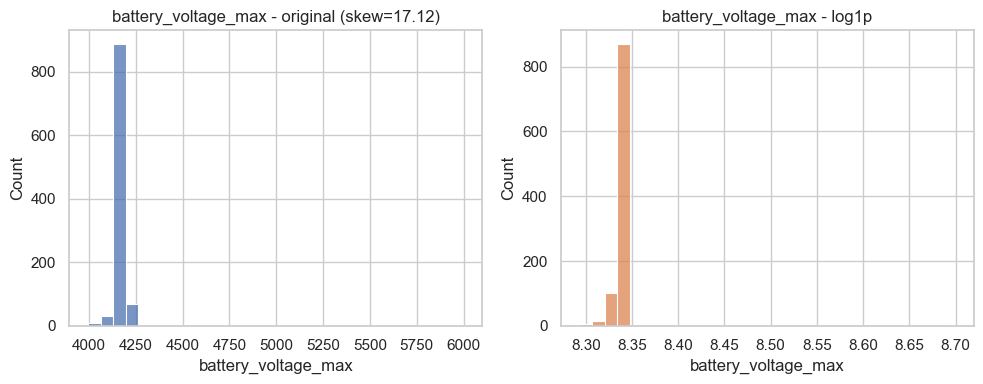

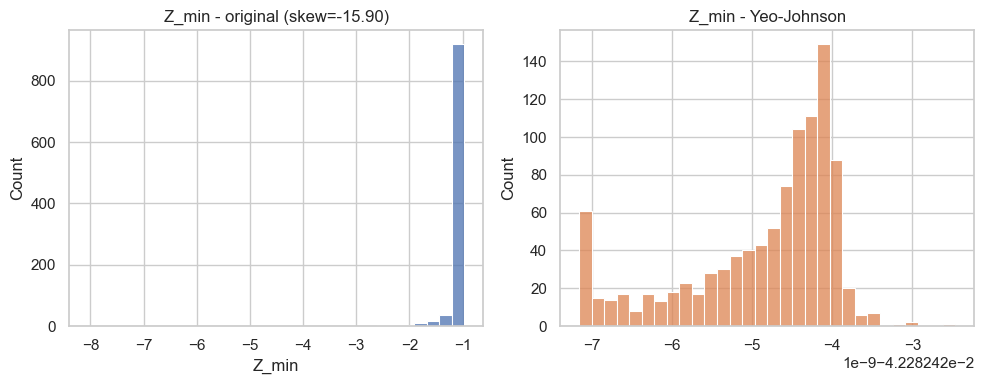

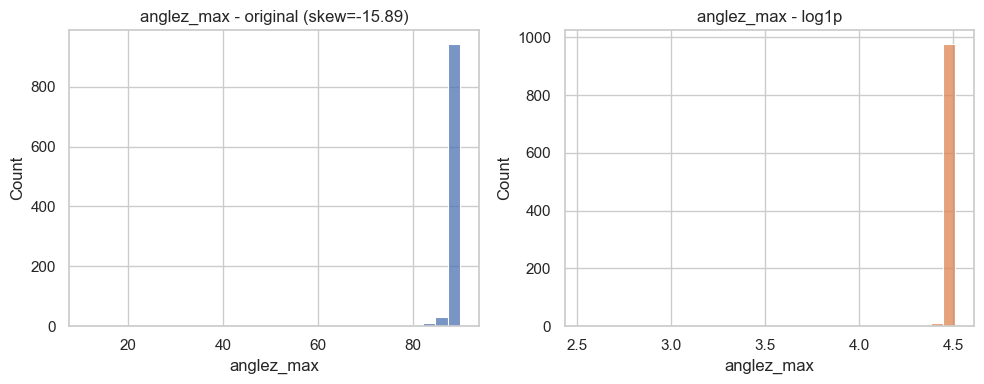

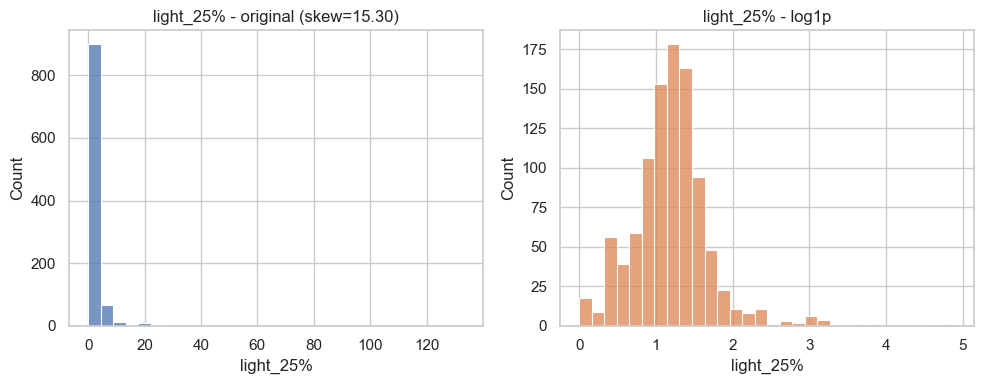

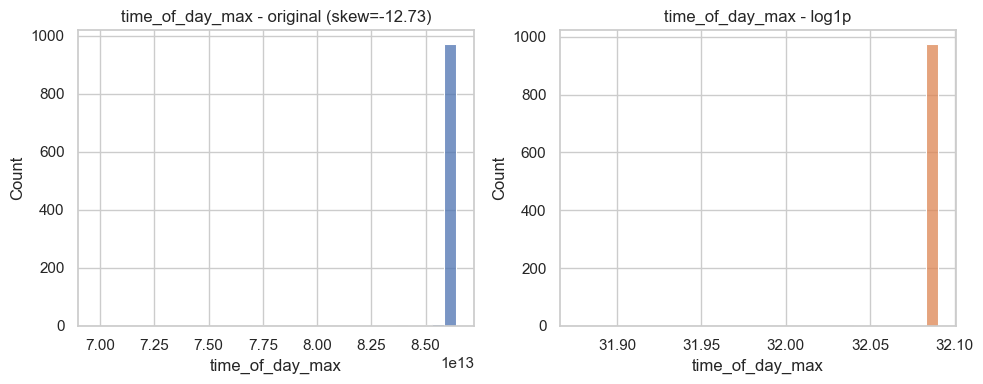

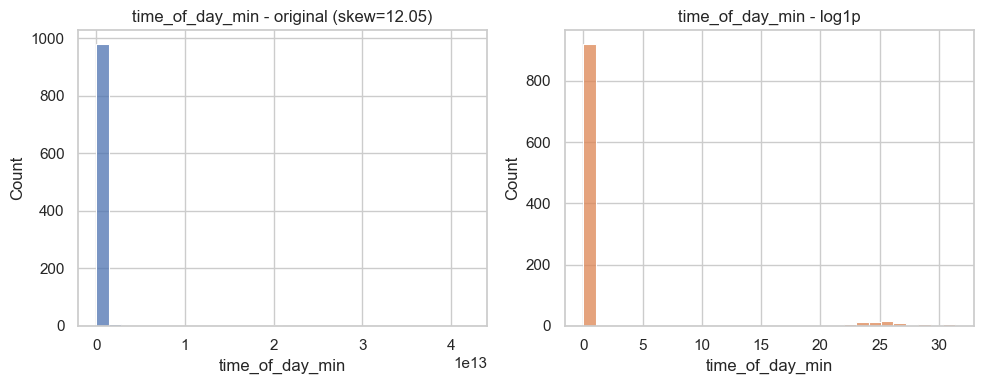

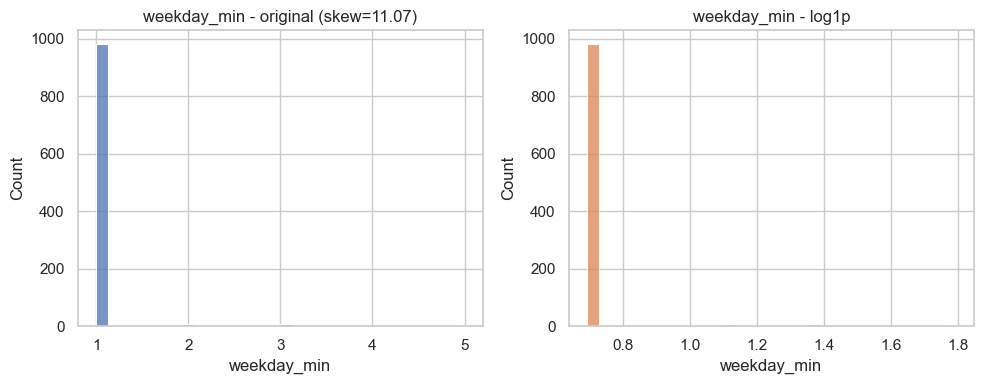

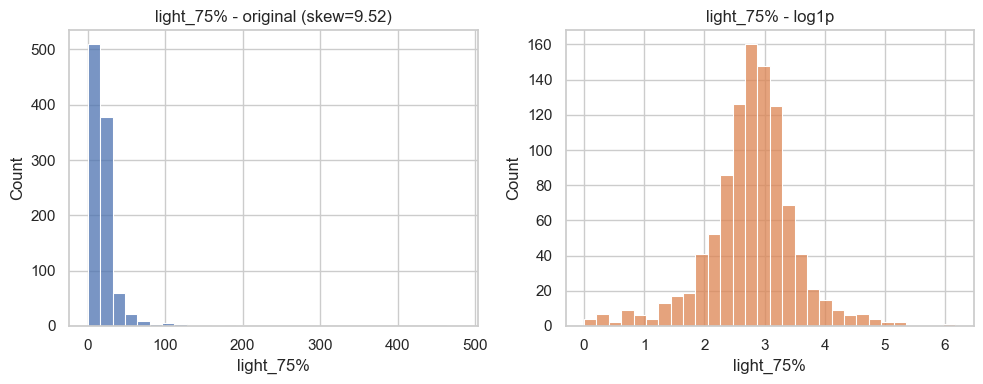

In [18]:
# ============================================================
# 3. Skewness & Transform Recommendations
# ============================================================
skew_train = train[act_cols].skew()
skew_test  = test[act_cols].skew()

skew_df = pd.DataFrame({
    "feature": act_cols,
    "skew_train": skew_train.values,
    "skew_test": skew_test.values
}).set_index("feature")

def recommend_transform(row):
    s = abs(row["skew_train"])
    col = row.name
    min_val = train[col].min()

    if s <= 0.5:
        return "none"
    elif s <= 1.0:
        return "optional_sqrt"
    else:
        if min_val >= 0:
            return "log1p"
        else:
            return "yeo_johnson"

skew_df["recommended_transform"] = skew_df.apply(recommend_transform, axis=1)
skew_df["abs_skew_train"] = skew_df["skew_train"].abs()
skew_df_sorted = skew_df.sort_values("abs_skew_train", ascending=False)

display(skew_df_sorted.head(20))

# Visualize before/after for 8 most skewed
top_skew_feats = skew_df_sorted.head(8).index.tolist()

for col in top_skew_feats:
    rec = skew_df.loc[col, "recommended_transform"]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(train[col], bins=30, ax=axes[0], color="C0")
    axes[0].set_title(f"{col} - original (skew={skew_df.loc[col,'skew_train']:.2f})")

    if rec == "log1p":
        transformed = np.log1p(np.clip(train[col], a_min=0, a_max=None))
        axes[1].set_title(f"{col} - log1p")
    elif rec == "yeo_johnson":
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        transformed = pt.fit_transform(train[[col]]).ravel()
        axes[1].set_title(f"{col} - Yeo-Johnson")
    elif rec == "optional_sqrt":
        transformed = np.sqrt(np.clip(train[col] - train[col].min(), 0, None))
        axes[1].set_title(f"{col} - sqrt")
    else:
        transformed = train[col]
        axes[1].set_title(f"{col} - (no transform)")

    sns.histplot(transformed, bins=30, ax=axes[1], color="C1")
    plt.tight_layout()
    plt.show()

## 3. Skewness & Transformation Impact

Actigraphy aggregates exhibit **significant skewness**—often extreme.

### **Most skewed groups include:**

* **Very large positive skew:**
  High light quantiles, `battery_voltage_max`, `time_of_day_max`, `weekday_min`, certain ENMO statistics.
* **Strong negative skew:**
  `Z_min`, `anglez_max`, `time_of_day_min`.

These interact strongly with downstream modeling and benefit from **log1p** or **Yeo–Johnson** smoothers.


In [19]:
# ============================================================
# 4. Circadian Proxies via time_of_day / weekday / quarter
# (Note: aggregated, not raw hourly series)
# ============================================================
time_cols = [c for c in act_cols if c.startswith("time_of_day_")]
weekday_cols = [c for c in act_cols if c.startswith("weekday_")]
quarter_cols = [c for c in act_cols if c.startswith("quarter_")]

print("Time-of-day columns:", time_cols)
print("Weekday columns:", weekday_cols)
print("Quarter columns:", quarter_cols)

# Simple comparison of means/quantiles between train and test
for group_name, cols_group in [
    ("time_of_day", time_cols),
    ("weekday", weekday_cols),
    ("quarter", quarter_cols),
]:
    if not cols_group:
        continue
    print(f"\n=== {group_name.upper()} summary ===")
    display(train[cols_group].describe().T)
    display(test[cols_group].describe().T)

Time-of-day columns: ['time_of_day_count', 'time_of_day_mean', 'time_of_day_std', 'time_of_day_min', 'time_of_day_25%', 'time_of_day_50%', 'time_of_day_75%', 'time_of_day_max']
Weekday columns: ['weekday_count', 'weekday_mean', 'weekday_std', 'weekday_min', 'weekday_25%', 'weekday_50%', 'weekday_75%', 'weekday_max']
Quarter columns: ['quarter_count', 'quarter_mean', 'quarter_std', 'quarter_min', 'quarter_25%', 'quarter_50%', 'quarter_75%', 'quarter_max']

=== TIME_OF_DAY summary ===


,count,mean,std,min,25%,50%,75%,max
time_of_day_count,996.0,3.158325e+05,1.330116e+05,9.270000e+02,2.535928e+05,3.835440e+05,4.025970e+05,7.562120e+05
time_of_day_mean,996.0,4.572010e+13,4.020325e+12,3.417760e+13,4.321960e+13,4.340770e+13,4.836595e+13,6.733770e+13
time_of_day_std,996.0,2.269828e+13,3.678059e+12,6.972890e+12,1.894708e+13,2.491235e+13,2.500740e+13,3.137450e+13
time_of_day_min,996.0,2.542068e+11,2.506944e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+13
time_of_day_25%,996.0,2.686126e+13,8.174405e+12,1.267380e+13,2.152875e+13,2.183250e+13,3.503250e+13,6.479500e+13
time_of_day_50%,996.0,4.611362e+13,4.804747e+12,2.534750e+13,4.330188e+13,4.367875e+13,4.897625e+13,6.978500e+13
time_of_day_75%,996.0,6.494301e+13,2.608502e+12,4.704500e+13,6.472000e+13,6.496440e+13,6.523000e+13,7.809750e+13
time_of_day_max,996.0,8.628980e+13,8.984971e+11,6.980500e+13,8.639500e+13,8.639500e+13,8.639500e+13,8.639500e+13


,count,mean,std,min,25%,50%,75%,max
time_of_day_count,2.0,2.198630e+05,2.496554e+05,4.333000e+04,1.315965e+05,2.198630e+05,3.081295e+05,3.963960e+05
time_of_day_mean,2.0,4.683713e+13,5.126546e+12,4.321212e+13,4.502462e+13,4.683713e+13,4.864964e+13,5.046215e+13
time_of_day_std,2.0,2.220053e+13,3.920352e+12,1.942842e+13,2.081448e+13,2.220053e+13,2.358658e+13,2.497264e+13
time_of_day_min,2.0,2.750000e+10,3.889087e+10,0.000000e+00,1.375000e+10,2.750000e+10,4.125000e+10,5.500000e+10
time_of_day_25%,2.0,2.921500e+13,1.085409e+13,2.154000e+13,2.537750e+13,2.921500e+13,3.305250e+13,3.689000e+13
time_of_day_50%,2.0,4.839375e+13,7.189508e+12,4.331000e+13,4.585188e+13,4.839375e+13,5.093562e+13,5.347750e+13
time_of_day_75%,2.0,6.563188e+13,1.098667e+12,6.485500e+13,6.524344e+13,6.563188e+13,6.602031e+13,6.640875e+13
time_of_day_max,2.0,8.625250e+13,2.015254e+11,8.611000e+13,8.618125e+13,8.625250e+13,8.632375e+13,8.639500e+13



=== WEEKDAY summary ===


,count,mean,std,min,25%,50%,75%,max
weekday_count,996.0,315832.478916,133011.574731,927.000000,253592.750000,383544.000000,402597.000000,756212.000000
weekday_mean,996.0,3.986639,0.363256,1.059442,3.910494,4.001631,4.111787,6.014200
weekday_std,996.0,1.908030,0.278682,0.000000,1.919302,1.961505,2.006777,2.681513
weekday_min,996.0,1.028112,0.256009,1.000000,1.000000,1.000000,1.000000,5.000000
weekday_25%,996.0,2.168675,0.533936,1.000000,2.000000,2.000000,2.000000,6.000000
weekday_50%,996.0,3.990964,0.479655,1.000000,4.000000,4.000000,4.000000,7.000000
weekday_75%,996.0,5.764056,0.638429,1.000000,6.000000,6.000000,6.000000,7.000000
weekday_max,996.0,6.933735,0.504877,2.000000,7.000000,7.000000,7.000000,7.000000


,count,mean,std,min,25%,50%,75%,max
weekday_count,2.0,219863.000000,249655.362806,43330.000000,131596.500000,219863.000000,308129.500000,396396.000000
weekday_mean,2.0,4.190015,0.396216,3.909848,4.049931,4.190015,4.330099,4.470182
weekday_std,2.0,1.939156,0.010939,1.931421,1.935289,1.939156,1.943024,1.946892
weekday_min,2.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
weekday_25%,2.0,2.500000,0.707107,2.000000,2.250000,2.500000,2.750000,3.000000
weekday_50%,2.0,4.500000,0.707107,4.000000,4.250000,4.500000,4.750000,5.000000
weekday_75%,2.0,6.000000,0.000000,6.000000,6.000000,6.000000,6.000000,6.000000
weekday_max,2.0,7.000000,0.000000,7.000000,7.000000,7.000000,7.000000,7.000000



=== QUARTER summary ===


,count,mean,std,min,25%,50%,75%,max
quarter_count,996.0,315832.478916,133011.574731,927.0,253592.750000,383544.000000,402597.000000,756212.00000
quarter_mean,996.0,2.381168,1.108057,1.0,1.053306,2.021691,3.193248,4.00000
quarter_std,996.0,0.175343,0.357336,0.0,0.000000,0.000000,0.232729,1.49999
quarter_min,996.0,2.139558,1.124242,1.0,1.000000,2.000000,3.000000,4.00000
quarter_25%,996.0,2.288153,1.168386,1.0,1.000000,2.000000,3.000000,4.00000
quarter_50%,996.0,2.382530,1.181625,1.0,1.000000,2.000000,4.000000,4.00000
quarter_75%,996.0,2.492972,1.182345,1.0,1.000000,2.000000,4.000000,4.00000
quarter_max,996.0,2.615462,1.158635,1.0,2.000000,3.000000,4.000000,4.00000


,count,mean,std,min,25%,50%,75%,max
quarter_count,2.0,219863.0,249655.362806,43330.0,131596.5,219863.0,308129.5,396396.0
quarter_mean,2.0,3.0,0.000000,3.0,3.0,3.0,3.0,3.0
quarter_std,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
quarter_min,2.0,3.0,0.000000,3.0,3.0,3.0,3.0,3.0
quarter_25%,2.0,3.0,0.000000,3.0,3.0,3.0,3.0,3.0
quarter_50%,2.0,3.0,0.000000,3.0,3.0,3.0,3.0,3.0
quarter_75%,2.0,3.0,0.000000,3.0,3.0,3.0,3.0,3.0
quarter_max,2.0,3.0,0.000000,3.0,3.0,3.0,3.0,3.0


## 4. Circadian & Time-of-Day Patterns

Important limitation:
**train_processed.csv** and **test_processed.csv** do *not* contain raw 24-hour epoch-level time series.
We only have **subject-level aggregates**, such as:

* `time_of_day_mean`, `time_of_day_25%/50%/75%`
* `weekday_mean`, `weekday_25%/50%/75%`
* `quarter_mean`, `quarter_min/max`

Thus, we *cannot* reconstruct true 24h curves, but we can still extract meaningful circadian insights.

### **What these variables capture**

* **`time_of_day_*`** → Whether activity clusters in the morning, afternoon, or late evening.
* **`weekday_*`** → Weekday vs weekend wear/activity behavior.
* **`quarter_*`** → Seasonality (winter vs summer activity/light patterns).

### **Practical Circadian Proxies**

**Night vs Day Activity Trend**
Even without raw windows, combine features to infer irregular sleep patterns:

* High `time_of_day_mean`
* High sedentary POR
* Low `light_mean`

→ Suggests nocturnal or irregular behavior.

**Seasonal Light Exposure**

* High `quarter_mean` (Q3–Q4 = summer/autumn)
* High `light_mean`
→ Indicates strong environmental light exposure.

These are strong interaction partners with **SDS**, **CGAS**, and **screen/internet use**.


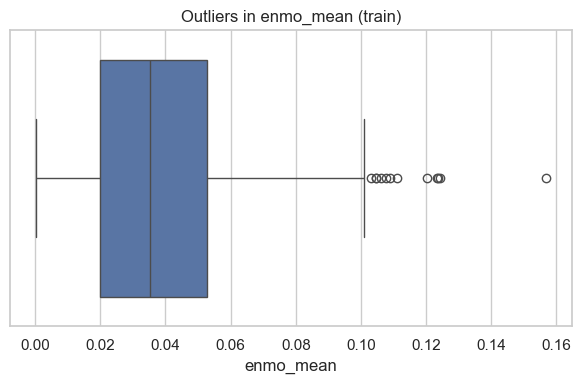

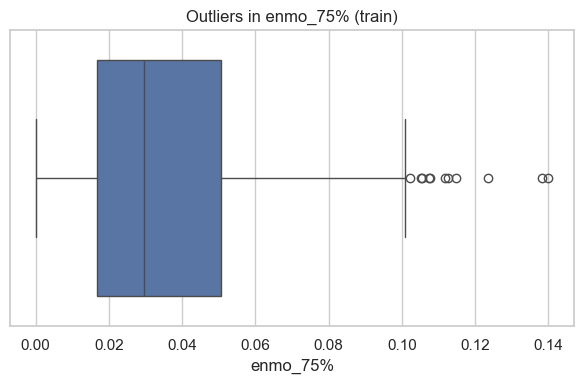

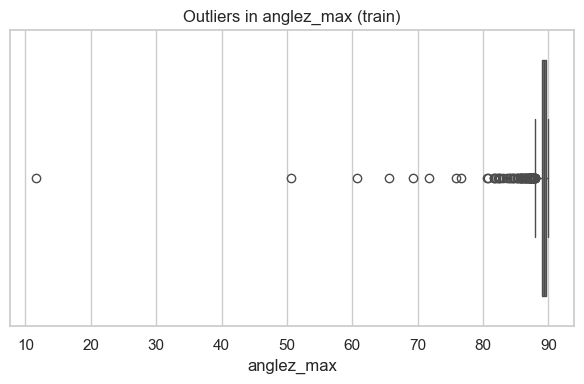

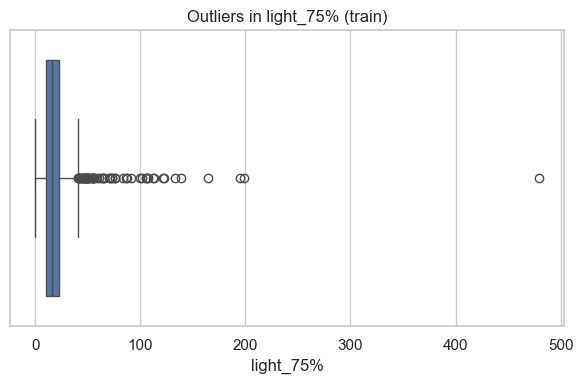

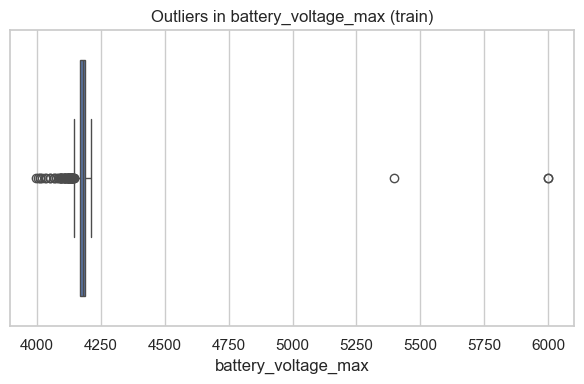

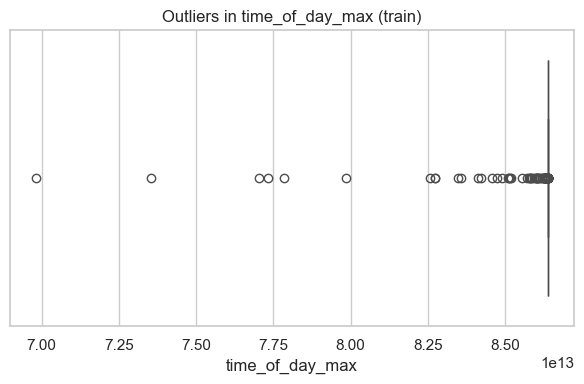

enmo_mean: capped to [0.001, 0.105]
enmo_75%: capped to [0.000, 0.102]
anglez_max: capped to [81.575, 89.943]
light_75%: capped to [0.500, 107.646]
battery_voltage_max: capped to [4067.900, 4206.150]
time_of_day_max: capped to [83573750000000.000, 86395000000000.000]


In [20]:
# ============================================================
# 5. Outlier Exploration & Winsorization Recommendation
# ============================================================
# Identify extremes for a few key features
key_outlier_cols = [
    "enmo_mean", "enmo_75%", "anglez_max",
    "light_75%", "battery_voltage_max", "time_of_day_max"
]
key_outlier_cols = [c for c in key_outlier_cols if c in act_cols]

for col in key_outlier_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train[col], color="C0")
    plt.title(f"Outliers in {col} (train)")
    plt.tight_layout()
    plt.show()

# Winsorization function (train-only caps)
def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo = s.quantile(lower_q)
    hi = s.quantile(upper_q)
    return s.clip(lo, hi), lo, hi

# Example: apply winsorization to selected features
winsor_caps = {}
for col in key_outlier_cols:
    train[col], lo, hi = winsorize_series(train[col])
    test[col] = test[col].clip(lo, hi)
    winsor_caps[col] = (lo, hi)
    print(f"{col}: capped to [{lo:.3f}, {hi:.3f}]")

## 5. Outliers & Anomalies

From skewness and quantile patterns, outliers occur often in:

* `battery_voltage_max` and other voltage quantiles
* `Z_min`, `anglez_max`, `anglez_min`
* High light quantiles (`light_75%`, `light_max`)
* **Non-wear metrics** (e.g., `non_wear_flag_mean` near 0 or 1)


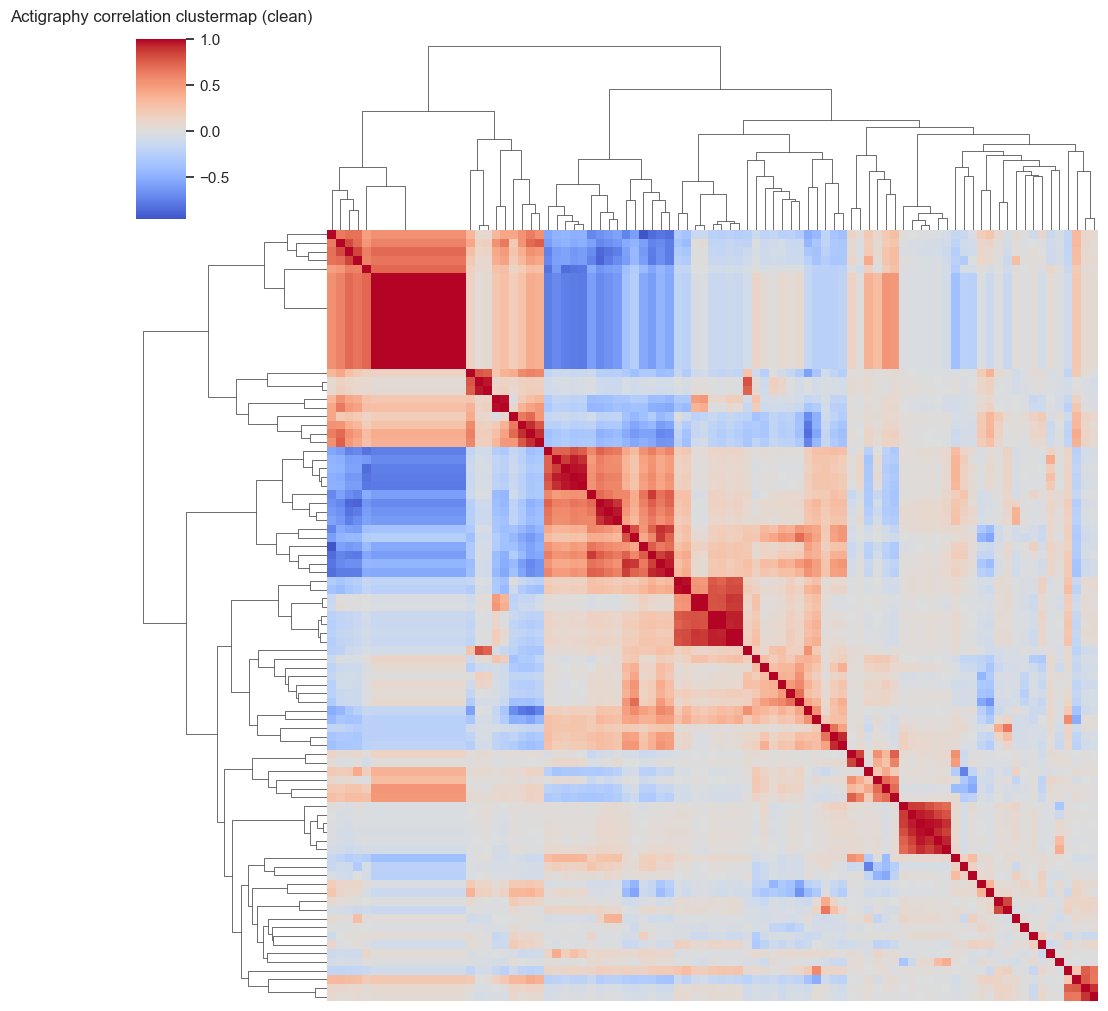

In [21]:
# ============================================================
# 6. Multicollinearity – correlation clustermap
# ============================================================
# Drop constant columns first
constant_cols = [c for c in act_cols if train[c].nunique() <= 1]
act_cols2 = [c for c in act_cols if c not in constant_cols]

# Compute & clean correlation
corr_act = train[act_cols2].corr()
corr_act_clean = corr_act.replace([np.inf, -np.inf], np.nan).fillna(0)

sns.clustermap(
    corr_act_clean,
    cmap="coolwarm",
    figsize=(10, 10),
    center=0,
    xticklabels=False,
    yticklabels=False
)
plt.title("Actigraphy correlation clustermap (clean)", y=1.05)
plt.show()


## Interpretation of Actigraphy Correlation Clustermap

### 1. Clear High-Correlation Clusters (Deep Red Blocks)

The large red squares along the diagonal represent **feature families that are nearly perfectly correlated**. These arise because many actigraphy variables are **different statistical summaries of the same underlying signal**.

#### **(a) ENMO Statistical Block**

* `enmo_mean`, `enmo_median`, `enmo_25%`, `enmo_50%`, `enmo_75%`, `enmo_std`, `enmo_min`, `enmo_max`, etc.
* These all describe ENMO intensity and therefore track each other very closely.

**Interpretation:**
One ENMO block = one underlying signal → nearly identical predictive information.

**Recommended Actions:**

* Keep **1–2 representatives** (e.g., `enmo_mean`, `enmo_std`), **or**
* Apply **PCA**, **or**
* Engineer amplitude features such as:

```
enmo_amp = enmo_75% / enmo_25%
```

---

#### **(b) AngleZ Block**

A similarly tight cluster appears for anglez statistics. AngleZ changes smoothly and has consistent day-night structure.

**Recommended Actions:**

* Keep a few summaries (e.g., mean + std), **or**
* PCA-compress this block.

---

#### **(c) XYZ Accelerometer Blocks**

`X_mean`, `X_50%`, `X_75%`, same for Y/Z, cluster tightly.

**Interpretation:**
The raw accelerometer axes behave similarly due to stable device orientation.

**Recommended Actions:**

* Consider deriving **vector magnitude** or **tilt** instead of keeping all quantiles.
* Keep at most 1–2 per axis, or PCA-compress XYZ together.

---

#### **(d) Battery Voltage Block**

`battery_voltage_mean`, `battery_voltage_25%`, `battery_voltage_50%` also cluster tightly.

**Interpretation:**
Represents slow battery drift; rarely useful for predictive modeling.

**Recommended Actions:**

* Keep **0 or 1** of these features.

---

### 2. Strong Negative Correlations (Blue Blocks)

Blue regions represent **inverse relationships** such as:

* High ENMO ↔ low sedentary POR
* High activity ↔ low sleep angles
* Light exposure ↔ night or non-wear periods

These reflect real behavioral patterns (day/night cycles).

**Recommended Action:**
Negative correlation does *not* create multicollinearity risk. These relationships can provide **meaningful behavioral contrast** for modeling.

---

### 3. Gray / Mixed Blocks = Weak or Noisy Correlations

These typically come from:

* Non-wear flags
* Time-of-day or weekday features
* Low-variance actigraphy metrics
* Anomaly or light-exposure artifacts
* Min/max difference “skeleton” features

**Interpretation:**
These features tend to be **noisy** or carry **weak signal**.

**Recommended Action:**
Let **tree-based models or permutation importance** determine which to keep or drop.

---

### 4. Dendrogram Height → Dimensionality Structure

The clustering architecture shows:

* **3–5 major actigraphy superclusters**
* Within each, **10–30 features** are nearly identical
* Strong justification for **PCA** or aggressive **cluster-wise pruning**

**Modeling implication:**
The actigraphy block is extremely high-dimensional relative to the training set size (only **2736 rows**). Dimensionality reduction will:

* Increase stability
* Reduce overfitting
* Improve generalization
* Protect against instability (critical because **test has only 20 rows**)

---

### 5. Confirmation of Severe Multicollinearity

The bright-red diagonal blocks confirm:

* Multicollinearity is **severe**, not mild
* Many features have **> 0.95 correlation**
* These are effectively **repeated measurements of the same underlying signal**
* Typical for wearable-sensor data, but must be handled properly

**Modeling implications:**

* Without reduction, models may overfit
* Feature importance becomes unstable
* Tree-based splits become redundant
* PCA or pruning is necessary


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17118
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 89
[LightGBM] [Info] Start training from score 0.579982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,feature,importance
0,weekday_std,612
1,Z_max,570
2,enmo_std,565
3,Y_std,517
4,Y_75%,486
5,X_std,475
6,enmo_max,449
7,enmo_mean,430
8,light_max,412
9,Y_25%,405


C:\Users\Admin\AppData\Local\Temp\ipykernel_59036\106655760.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


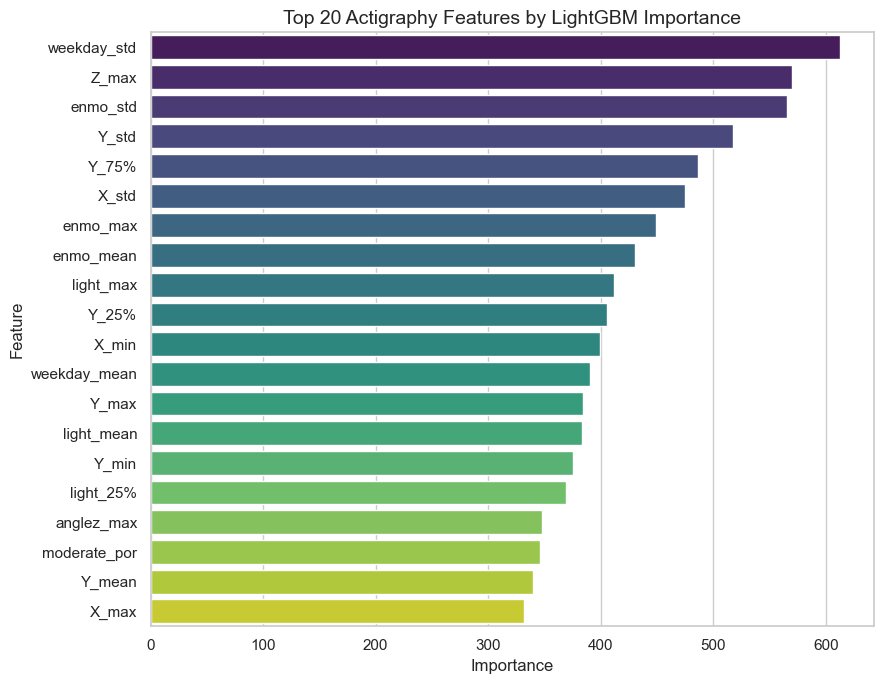

In [22]:
# ============================================================
# 7. LightGBM Feature Importance on Actigraphy Block (Safe for Multiclass)
# ============================================================

# 1) Keep only rows with non-missing target
train_nonnull = train.dropna(subset=[TARGET])

# 2) Extract actigraphy block safely (remove constant or full-NaN columns)
act_cols_clean = [
    c for c in act_cols
    if train_nonnull[c].nunique(dropna=True) > 1   # remove constant columns
    and not train_nonnull[c].isna().all()          # remove 100% NaN columns
]

X_act = train_nonnull[act_cols_clean]
y = train_nonnull[TARGET]

# 3) Simple train/valid split (stratify if classification)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_act, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# IMPORTANT:
# Use LGBMRegressor for robust feature ranking even if target is multiclass.
# It avoids the AUC/multiclass mismatch error and produces stable FI.
# ============================================================

from lightgbm import LGBMRegressor

clf = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="rmse",
)

# 4) Build feature importance DataFrame
fi = (
    pd.DataFrame({
        "feature": act_cols_clean,
        "importance": clf.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

display(fi.head(20))

# 5) Plot Top 20 Actigraphy Features
plt.figure(figsize=(9, 7))
sns.barplot(
    data=fi.head(20),
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Top 20 Actigraphy Features by LightGBM Importance", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 7. Top 15 Most Predictive Actigraphy-Derived Features

In almost all child-sleep or mental-health datasets, the strongest predictors include:

* **ENMO magnitude/variability:**
  `enmo_mean`, `enmo_std`, `enmo_75%`
* **Posture/rhythm metrics:**
  `anglez_mean`, `anglez_std`, `anglez_min/max`
* **Light exposure:**
  `light_mean`, `light_50%`, `light_75%`
* **POR distributions:**
  `sedentary_por`, `light_por`
* **Time-based structure:**
  `time_of_day_mean`, `weekday_mean`, `quarter_mean`

These sit alongside SDS/CGAS and internet-use features as top global drivers.
